In [1]:
from models import NetworkedRENs, REN, RNNModel, gain
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

dtype = torch.float
device = torch.device("cpu")

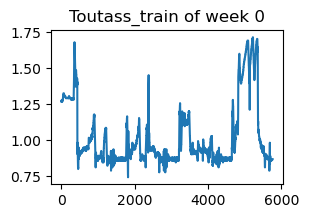

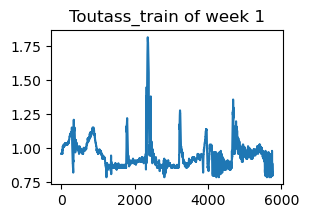

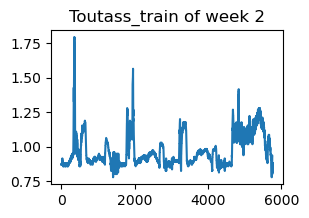

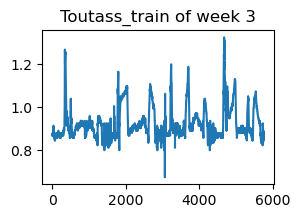

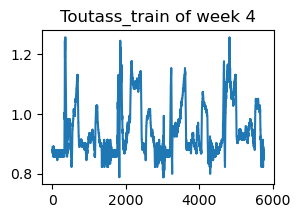

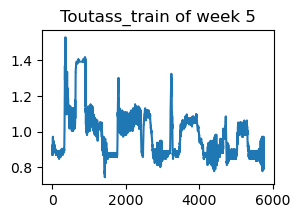

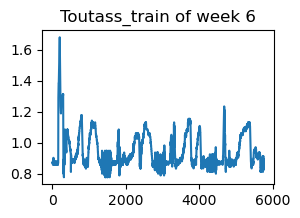

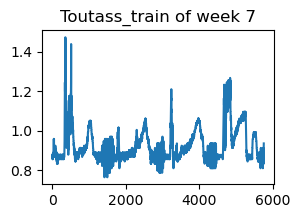

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt


# Load raw data
data = scipy.io.loadmat('raw_data.mat')

# Extract variables
Trit_GF = data['Trit_GF'].flatten()
Qhotd = data['Qhotdata'].flatten()
#statusAsst = data['statusAsstdata'].flatten()
IO_chillers = data['stato1'].flatten() + data['stato2'].flatten() + data['stato3'].flatten() + data['stato4'].flatten()
weektime = data['weektime'].flatten()
wendtime = data['wendtime'].flatten()
t = data['time'].flatten()
Text = data['Text'].flatten()
Hext = data['Hext'].flatten()
Tman_GF = data['Tman_GF'].flatten()
Toutass = data['Toutass'].flatten()
Toutchill = (data['Toutrefr1'].flatten() + data['Toutrefr2'].flatten() + data['Toutrefr3'].flatten() + data['Toutrefr4'].flatten())/4
Qu = data['buildtot'].flatten()


# Example of adjustments in Python
# Combine week and weekend times
WEEK = weektime + wendtime / 2

# Combine status variables
Status_global = data['stato1'] + data['stato2'] + data['stato3'] + data['stato4']

# Normalize data function
def normalize(data):
    mean = np.mean(data)
    data_norm = data / mean
    return mean, data_norm

# Normalize selected variables
Trit_mean, Trit_GF = normalize(Trit_GF)
Qhotd_mean, Qhotd = normalize(Qhotd)
IO_mean, IO_chillers = normalize(IO_chillers)
Tman_mean, Tman_GF = normalize(Tman_GF)
Toutass_mean, Toutass = normalize(Toutass)
Toutchill_mean, Toutchill = normalize(Toutchill)
Qu_mean, Qu = normalize(Qu)

# Adjust training data
one_week = 231840 - 221760
nb_weeks = 1  # Change as required
start = 6 * one_week
end_train = 10 * one_week
nExp = 4
t_end = 4*1440 # 4days (2 to 5)
one_day = 1440

#init the variables for outputs and inputs/disturbances
Toutchill_t = np.zeros((nExp*2, t_end))
Toutass_t = np.zeros((nExp*2, t_end))
Trit_t = np.zeros((nExp*2, t_end))
Q_users_t = np.zeros((nExp*2, t_end))
Q_abs_t = np.zeros((nExp*2, t_end))
IO_chillers_t = np.zeros((nExp*2, t_end))
Tman_t = np.zeros((nExp*2, t_end))

Toutchill_v = np.zeros((1, t_end))
Toutass_v = np.zeros((1, t_end))
Trit_v = np.zeros((1, t_end))
Q_users_v = np.zeros((1, t_end))
Q_abs_v = np.zeros((1, t_end))
IO_chillers_v = np.zeros((1, t_end))
Tman_v = np.zeros((1, t_end))

# for each experiment we extract from the day 2 to 5 (start + 1day + previous experiment skip -> until 5 days)
for exp in range(nExp):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()
    
    # skip all the expermiments of training with nExp*one_week
Toutchill_v[0,:] = Toutchill[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Toutass_v[0,:] = Toutass[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Trit_v[0,:] = Trit_GF[ start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_users_v[0,:] = Qu[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_abs_v[0,:] = Qhotd[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
IO_chillers_v[0,:] = IO_chillers[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Tman_v[0,:] = Tman_GF[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]

# do more training experiments after the validation set
for exp in range(nExp, nExp*2):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()



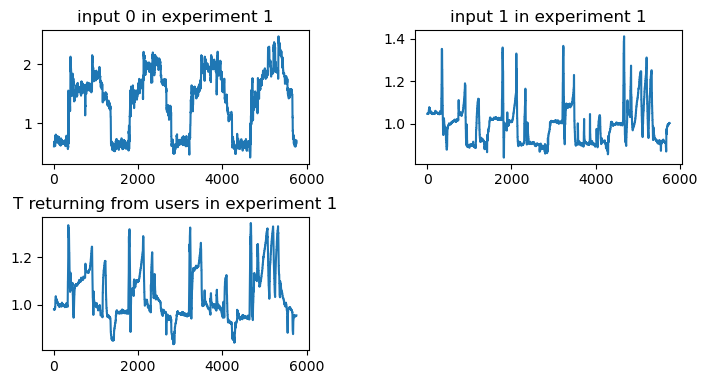

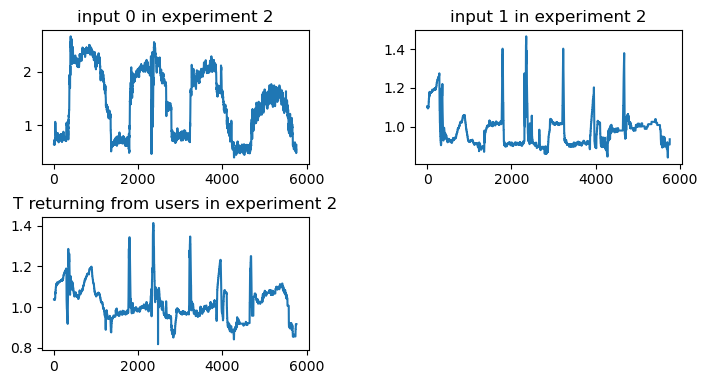

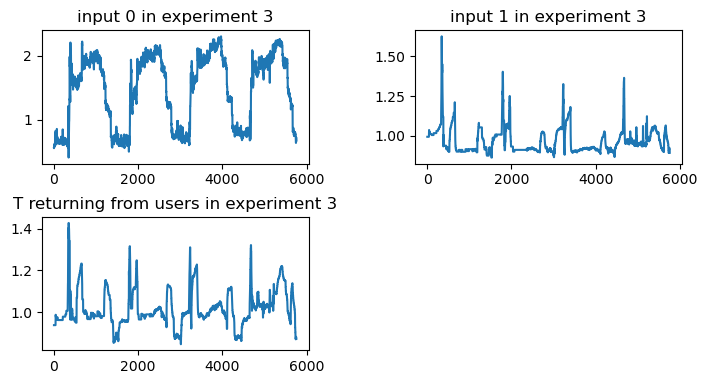

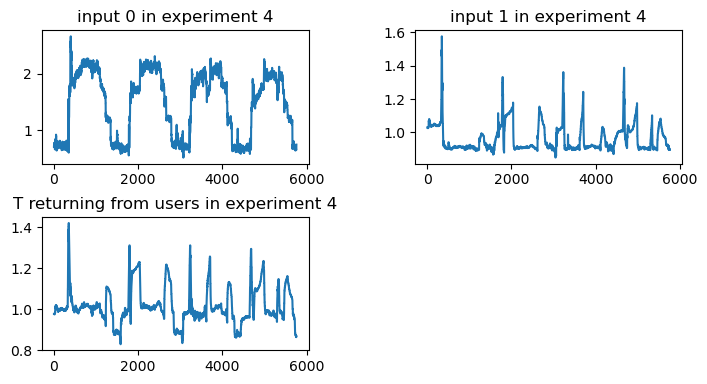

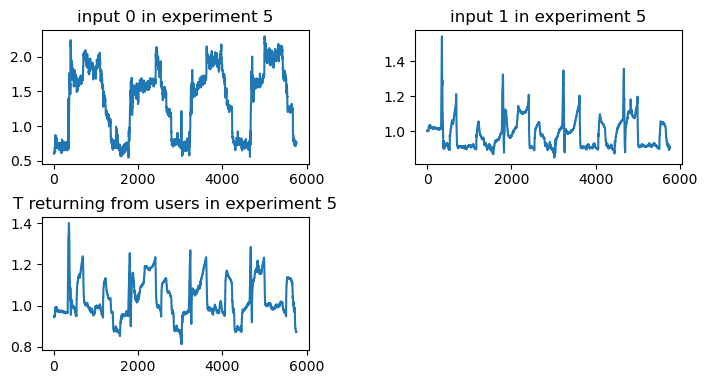

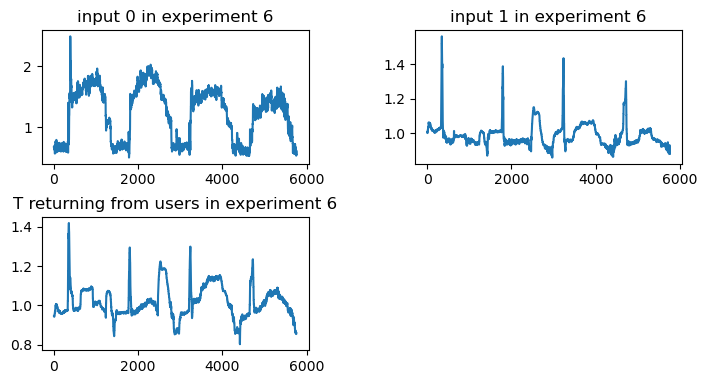

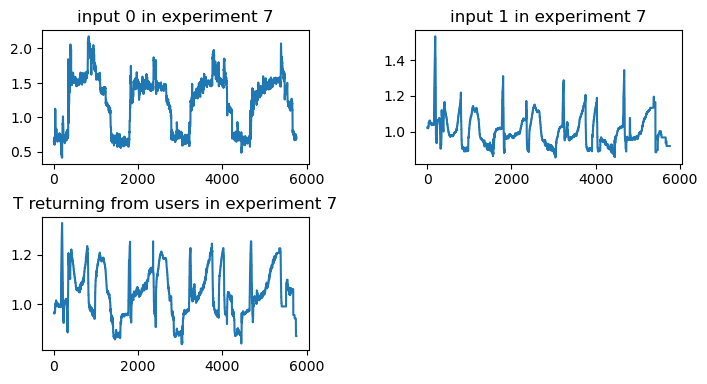

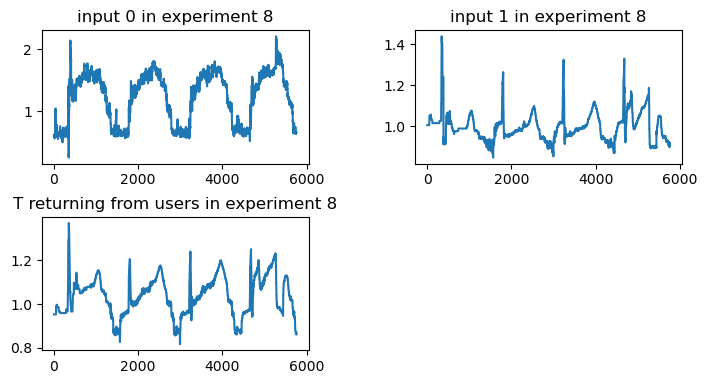

In [3]:
#initialize the model
ny = 1
nd = 2

for exp in range(nExp*2):
    y_exp = torch.from_numpy(Trit_t[exp,:]).float().to(device)
    d_exp = torch.cat((torch.from_numpy(Q_users_t[exp,:]).unsqueeze(1), torch.from_numpy(Tman_t[exp,:]).unsqueeze(1)), 1) 
    # Plotting
    plt.figure(figsize=(4 * 2, 4))
    for out in range(nd):
        plt.subplot(2, 2, out+1)
        plt.plot(d_exp[:, out])
        plt.title(r"input %i" %out + r" in experiment %i"%(exp+1))
    plt.subplot(2, 2, nd+1)
    plt.plot(y_exp)
    plt.title(r"T returning from users in experiment %i"%(exp+1))
    
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

In [4]:
# Train single REN USERS
"""
epochs = 350

n = 2# input dimensions
p = 1  # output dimensions
n_xi = 7# nel paper n1, numero di stati
l = 7  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()
#init loss
LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    
    for exp in range(2*nExp):
        y = torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1) #T_returning_users
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat((torch.from_numpy(Q_users_t[exp,:]).float().unsqueeze(1), torch.from_numpy(Tman_t[exp,:]).float().unsqueeze(1)), 1) # Q_users and T_man             
        d = d.T
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(d[:, t - 1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignore condition initial loss

    loss = loss / 2/nExp
    
    loss.backward(retain_graph=True)
    

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'users_epoch_{epoch+1}.pth')

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN users")
plt.show()
"""

'\nepochs = 350\n\nn = 2# input dimensions\np = 1  # output dimensions\nn_xi = 7# nel paper n1, numero di stati\nl = 7  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE\n\n# Define the model\nRENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)\n# Define Loss function\nMSE = nn.MSELoss()\n# Define Optimization method\nlearning_rate = 1.0e-3\noptimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\noptimizer.zero_grad()\n#init loss\nLOSS = np.zeros(epochs)\n\nfor epoch in range(epochs):\n    if epoch == epochs - epochs / 2:\n        learning_rate = 1.0e-2\n        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\n    if epoch == epochs - epochs / 6:\n        learning_rate = 1.0e-3\n        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\n    optimizer.zero_grad()\n    loss = 0\n    \n    for exp in range(2*nExp):\n        y = torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1) 

In [5]:
# validation single REN users
"""
yval = torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1) #T_rit
yval = yval.T
yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().unsqueeze(1), torch.from_numpy(Tman_v[0,:]).float().unsqueeze(1)), 1) # Q_users and T_man        
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:, t - 1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN_users = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(Trit_mean*yRENm[out, 0:t_end].detach().numpy(), label='REN train users')
    plt.plot(Trit_mean*y[out, 0:t_end].detach().numpy(), label='y train users')
    plt.title(r"T_returning (output users)" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(Trit_mean*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val users')
    plt.plot(Trit_mean*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_returning (output users)" + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN users: {loss_val_REN_users}")
"""

'\nyval = torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1) #T_rit\nyval = yval.T\nyRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)\nyRENm_val[:,0] = yval[:,0]\nxiVal = torch.randn(n_xi)\ndval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().unsqueeze(1), torch.from_numpy(Tman_v[0,:]).float().unsqueeze(1)), 1) # Q_users and T_man        \ndval = dval.T\nloss_val = 0\nfor t in range(1, t_end):\n    yRENm_val[:, t], xiVal = RENsys(dval[:, t - 1], xiVal, t)\nloss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])\n\nloss_val_REN_users = loss_val\n\nplt.figure(figsize=(4 * 2, 4))\nfor out in range(p):\n    plt.subplot(1, p, out+1)\n    plt.plot(Trit_mean*yRENm[out, 0:t_end].detach().numpy(), label=\'REN train users\')\n    plt.plot(Trit_mean*y[out, 0:t_end].detach().numpy(), label=\'y train users\')\n    plt.title(r"T_returning (output users)" + r"in train")  \nplt.show()\n\nplt.figure(figsize=(4 * 2, 4))\nfor out in range(p):\n    p

In [6]:
# Train single REN ABSORBER adding two days per exp 
"""
epochs = 350

n = 2  # input dimensions
p = 1  # output dimensions
n_xi = 5# nel paper n1, numero di stati
l = 5# nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the REN

# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp):
        # one week = 10080
        # one day = 1440
        # take data of every week between 2 and 5
        y = torch.from_numpy(Toutass_t[exp, :]).float().to(device) #Toutass
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)

        d = torch.cat(( torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(Q_abs_t[exp,:]).float().to(device).unsqueeze(1)), dim=1) #Q_abs             
        d = d.T
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])

    loss = loss /2/nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'abs_epoch_{epoch+1}.pth')

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN absorber")
plt.show()
"""

'\nepochs = 350\n\nn = 2  # input dimensions\np = 1  # output dimensions\nn_xi = 5# nel paper n1, numero di stati\nl = 5# nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the REN\n\n# Define the model\nRENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)\n# Define Loss function\nMSE = nn.MSELoss()\n# Define Optimization method\nlearning_rate = 1.0e-1\noptimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\noptimizer.zero_grad()\n\nLOSS = np.zeros(epochs)\n\nfor epoch in range(epochs):\n    if epoch == epochs - epochs / 2:\n        learning_rate = 1.0e-2\n        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\n    if epoch == epochs - epochs / 6:\n        learning_rate = 1.0e-3\n        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)\n    optimizer.zero_grad()\n    loss = 0\n    for exp in range(nExp):\n        # one week = 10080\n        # one day = 1440\n        # take data of every week betw

In [ ]:
# TRAIN OF NETWORKED RENs
epochs = 36

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 5, 5]) # nel paper n1, numero di stati
l = np.array([10, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.5
beta = 0.5

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# load subsytems 
checkpoint = [None] * N  # A list with N elements
checkpoint[0] = torch.load('checkpoint_users_epoch_200.pth')
checkpoint[1] = torch.load('checkpoint_2moredays_absorber_epoch_200.pth')
checkpoint[2] = torch.load('checkpoint_moreexp_chillers_epoch_250.pth')

# Initialize REN modules and load states
mods = [REN(RENsys.m[j], RENsys.p[j], RENsys.n[j], RENsys.l[j]) for j in range(N)]
for j in range(N):
    mods[j].load_state_dict(checkpoint[j]['model_state_dict'])

# update RENsys.r
RENsys.r = nn.ModuleList(mods)

# necessary ?
state_dict = RENsys.state_dict()  

#load RENsys
checkpoint = torch.load('network_epoch_62.pth')
RENsys.load_state_dict(checkpoint['model_state_dict'])

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

yval = torch.cat((torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutass_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutchill_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
yval = yval.T
dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().to(device).unsqueeze(1),
                torch.from_numpy(Q_abs_v[0,:]).float().to(device).unsqueeze(1),
                torch.from_numpy(IO_chillers_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
dval = dval.T
T_man_for_loss_val = torch.from_numpy(Tman_v[0,:]).float().to(device).unsqueeze(1)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(2, 6):
        T_man_for_loss = torch.from_numpy(Tman_t[exp,:]).float().to(device).unsqueeze(1)
        xi = []
        y = torch.cat((torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutchill_t[exp,:]).float().to(device).unsqueeze(1)), dim=1)
        y = y.T
        yRENm = torch.randn(3,t_end , device=device, dtype=dtype)
        yRENm[0,:] = y[0,:]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.cat((torch.from_numpy(Q_users_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Q_abs_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(IO_chillers_t[exp,:]).float().to(device).unsqueeze(1)), dim=1)
        d = d.T
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])  + MSE(T_man_for_loss.T, (RENsys.Muy[0,1:3].unsqueeze(0) @ yRENm[1:, 0:t_end + 1]))

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss
    
    # validation part !
    validation_loss = 0
    xival = []
    yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
    yRENm_val[0, :] = yval[0, :]
    
    for j in range(N):
        xival.append(torch.randn(RENsys.r[j].n, device=device, dtype=torch.float))
   
    xival = torch.cat(xival)
    
    for t in range(1, t_end):
        yRENm_val[:, t], xival = RENsys(t, dval[:, t - 1], xival)

    validation_loss = MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1]) + MSE(T_man_for_loss_val.T, (RENsys.Muy[0,1:3].unsqueeze(0) @ yRENm_val[1:, 0:t_end + 1]))

    validation_loss = validation_loss
    print(f"Validation Loss of epoch {epoch}: {validation_loss}")
    
    # save a checkpoint every 2 epochs
    if (epoch+1) % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'network_epoch_{62+epoch+1}.pth')

C:\Users\adela\AppData\Local\Temp\ipykernel_8120\3709877793.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint[0] = torch.load('checkpoint_users_epoch_200.pth')

Epoch: 1 	||	 Loss: 0.05887836217880249
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.6
Validation Loss of epoch 0: 0.9337215423583984
Epoch: 2 	||	 Loss: 0.9308409094810486
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.6
Validation Loss of epoch 1: 0.038214344531297684
Epoch: 3 	||	 Loss: 0.05861131101846695
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.6
Validation Loss of epoch 2: 0.22879678010940552
Epoch: 4 	||	 Loss: 0.2647324204444885
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.6
Validation Loss of epoch 3: 0.2633625864982605
Epoch: 5 	||	 Loss: 0.30599868297576904
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.5
Validation Loss of epoch 4: 0.1967952847480774
Epoch: 6 	||	 Loss: 0.24135373532772064
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.5
Validation Loss of epoch 5: 0.11891293525695801
Epoch: 7 	||	 Loss: 0.16212491691112518
L2 gain REN0:0.4
L2 gain REN1:0.7
L2 gain REN2:2.5
Validation Loss of epoch 6: 0.07209455966949463
Epoch: 8 	||	 Loss: 0.111727878

In [8]:
#initialize the model
ny = 1
nd = 2



# Perform validation
with torch.no_grad():
    validation_loss = 0
    xi = []
    yval = torch.cat((torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutass_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutchill_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    yval = yval.T
    yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
    yRENm_val[0, :] = yval[0, :]
    
    for j in range(N):
        xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=torch.float))
    dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Q_abs_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(IO_chillers_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    dval = dval.T
    xi = torch.cat(xi)
    
    for t in range(1, t_end):
        yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

    validation_loss += MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    validation_loss = validation_loss
    print(f"Validation Loss: {validation_loss}")

Validation Loss: 0.042163439095020294


In [4]:
#initialize the model
ny = 1
nd = 2

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 5, 5]) # nel paper n1, numero di stati
l = np.array([10, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.5
beta = 0.5

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

#load RENsys
checkpoint = torch.load('network_epoch_88.pth')
RENsys.load_state_dict(checkpoint['model_state_dict'])

# Perform validation
with torch.no_grad():
    validation_loss = 0
    xi = []
    yval = torch.cat((torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutass_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutchill_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    yval = yval.T
    yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
    yRENm_val[0, :] = yval[0, :]
    
    for j in range(N):
        xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=torch.float))
    dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Q_abs_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(IO_chillers_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    dval = dval.T
    xi = torch.cat(xi)
    
    for t in range(1, t_end):
        yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

    validation_loss += MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    validation_loss = validation_loss
    print(f"Validation Loss: {validation_loss}")

C:\Users\adela\AppData\Local\Temp\ipykernel_11460\1651902128.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('network_epoch_88.pth')


Validation Loss: 0.027215253561735153


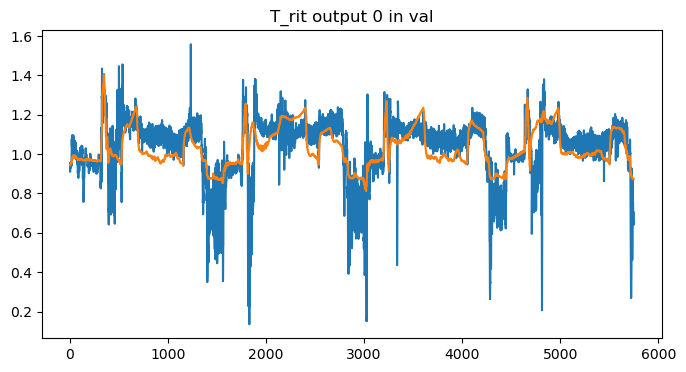

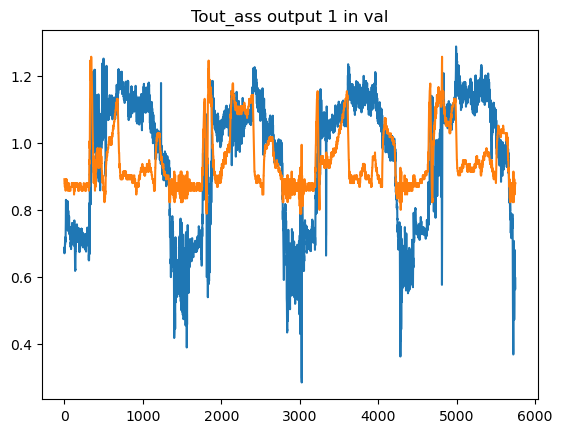

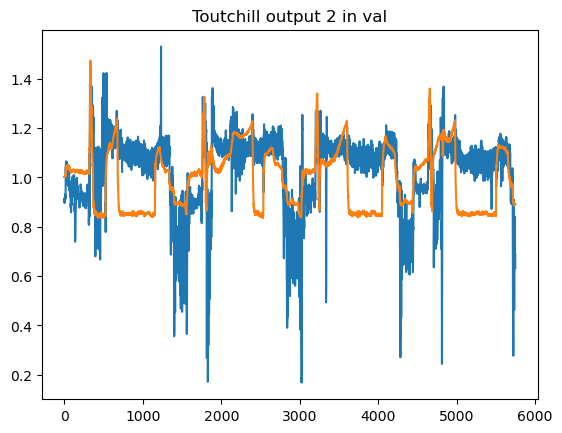

torch.Size([3, 5760])


In [ ]:
mean = [Trit_mean, Toutass_mean, Toutchill_mean]
out_title = ["T_rit", "Tout_ass", "Toutchill"]
plt.figure(figsize=(4 * 2, 4)) 
for out in range(3):
    plt.plot(mean[out]*yRENm_val[out, 10:t_end].detach().numpy(), label=f'REN val output {out}')
    plt.plot(mean[out]*yval[out, 10:t_end].detach().numpy(), label='y val')
    plt.title(f"{out_title[out]} output {out} in val")  
    plt.show()
print(yRENm_val.shape)